Name : Sudharshan Vijayaragavan

Reg No. : 3122237001054

Email Spam or Ham Classification using Na¨ıve Bayes, KNN, and
SVM

Configuration Section (User-Editable Block)

1) Load and Preprocess Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive

# Config
DATA_PATH = "/content/drive/MyDrive/spambase_csv.csv"
TARGET_COLUMN = 'class'
TEST_SIZE = 0.2
RANDOM_STATE = 42
KFOLD_SPLITS = 5

# Mount drive and load CSV
drive.mount('/content/drive')
df = pd.read_csv(DATA_PATH)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Handle missing and set target type
df = df.dropna()
df[TARGET_COLUMN] = df[TARGET_COLUMN].astype('category')

# Feature/Target split
X_raw = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train-test split (both raw and scaled)
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
X_scaled_train, X_scaled_test, _, _ = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


Mounted at /content/drive
Columns: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_

2. Perform EDA (class balance, feature distributions)

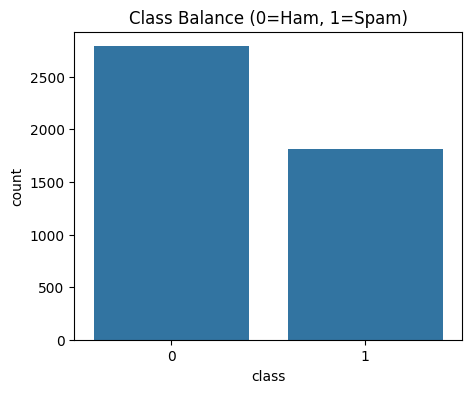

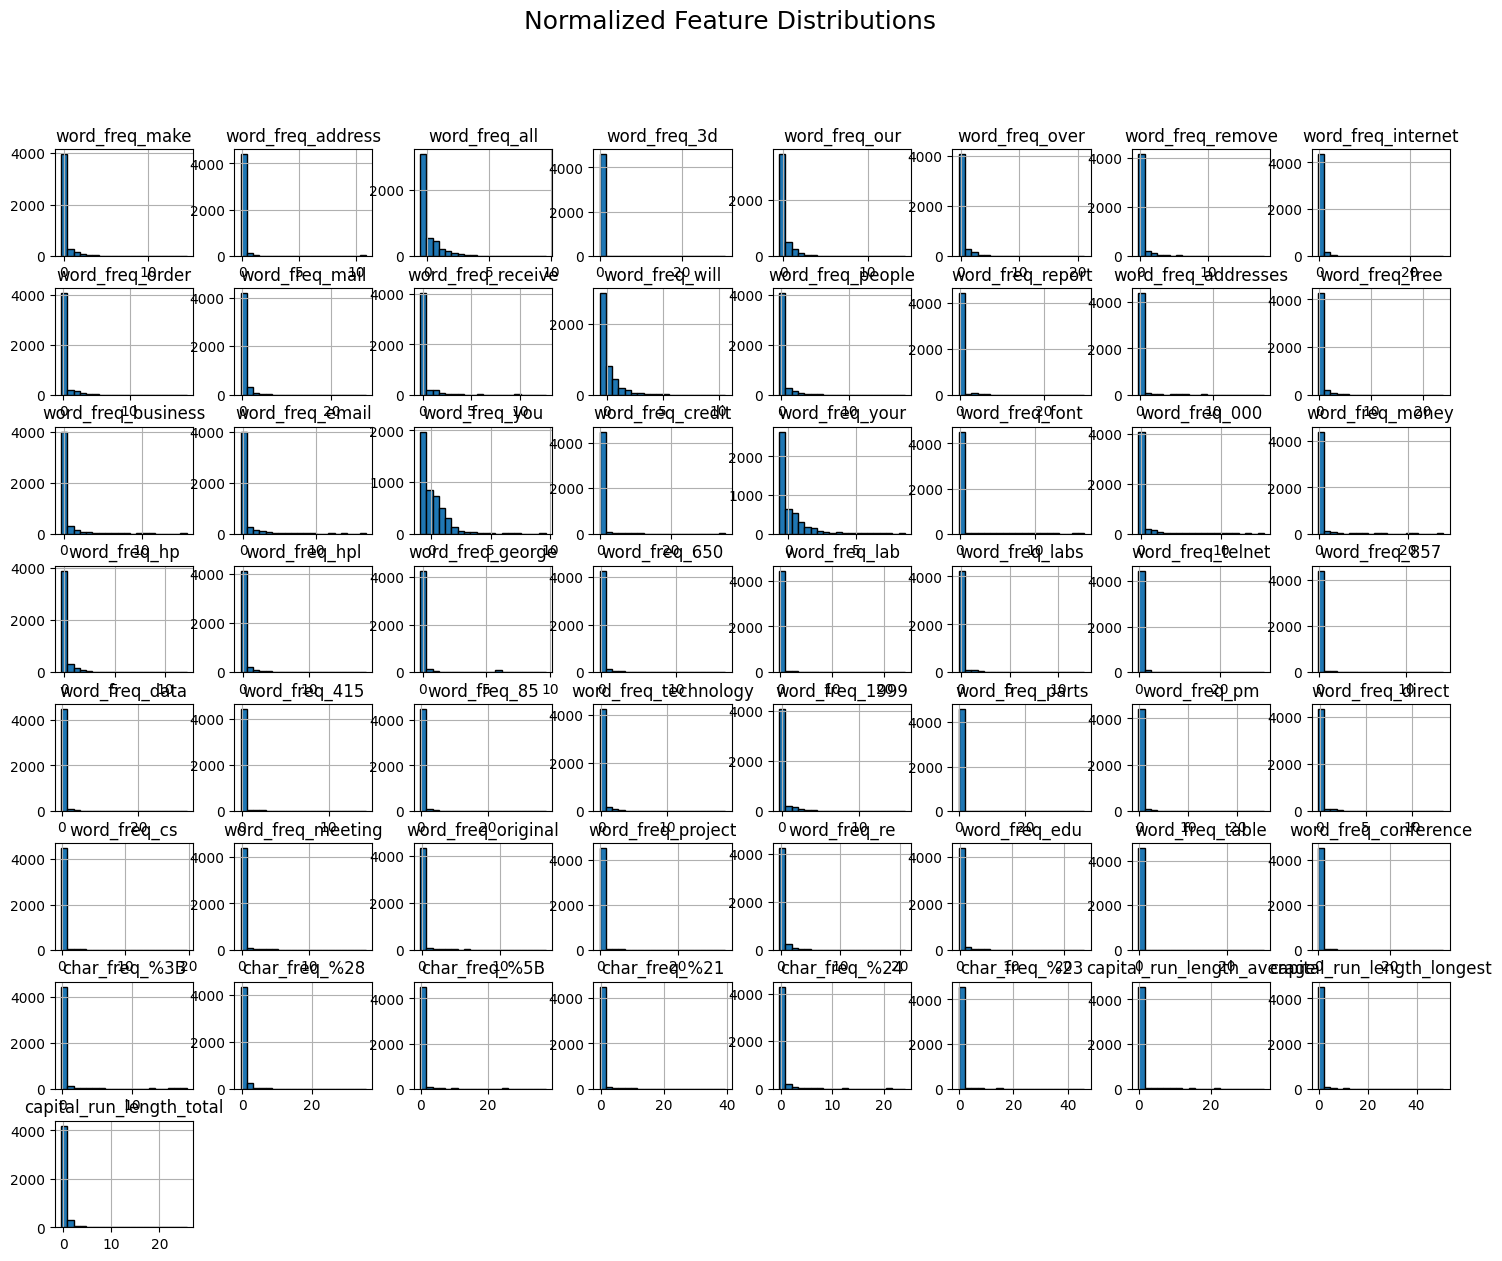

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Class Balance (0=Ham, 1=Spam)")
plt.show()

X_df = pd.DataFrame(X_scaled, columns=X_raw.columns)
X_df.hist(figsize=(18,14), bins=20, edgecolor='black')
plt.suptitle("Normalized Feature Distributions", fontsize=18)
plt.show()

3) Define Models

In [ ]:
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "KNN_k=3": KNeighborsClassifier(n_neighbors=3, algorithm='auto'),
    "KNN_k=5_KDTree": KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'),
    "KNN_k=7_BallTree": KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree'),
    "SVM_Linear": SVC(kernel='linear', C=1.0, probability=True),
    "SVM_Polynomial": SVC(kernel='poly', degree=3, C=1.0, gamma='scale', probability=True),
    "SVM_RBF": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    "SVM_Sigmoid": SVC(kernel='sigmoid', C=1.0, gamma='scale', probability=True),
}


4) Train Models (NB, KNN, SVM)

In [ ]:
# Clear results (avoid duplicates if re-running)
nb_results, knn_k_results, knn_tree_results, svm_results, cv_results = [], [], [], [], []

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    try:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test.cat.codes, y_scores)
        auc_score = roc_auc_score(y_test.cat.codes, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"ROC Curve skipped for {name}: {e}")

def evaluate_and_store(name, model, X_train, y_train, X_test, y_test, category):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    if category == "NB":
        nb_results.append([name, acc, prec, rec, f1, train_time])
    elif category == "KNN_k":
        knn_k_results.append([name, acc, prec, rec, f1])
    elif category == "KNN_tree":
        knn_tree_results.append([name, acc, prec, rec, f1, train_time])
    elif category == "SVM":
        svm_results.append([name, acc, f1, train_time])
    evaluate_model(name, model, X_test, y_test)


5) Train and Evaluate All Models

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       558
           1       0.72      0.95      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.85      0.83       921
weighted avg       0.87      0.83      0.84       921



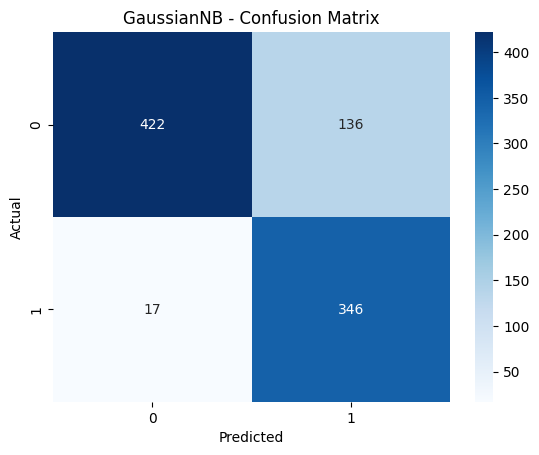

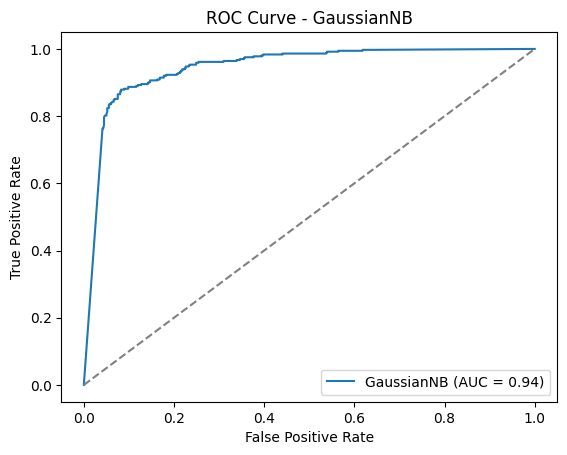

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       558
           1       0.72      0.71      0.71       363

    accuracy                           0.78       921
   macro avg       0.77      0.76      0.77       921
weighted avg       0.78      0.78      0.78       921



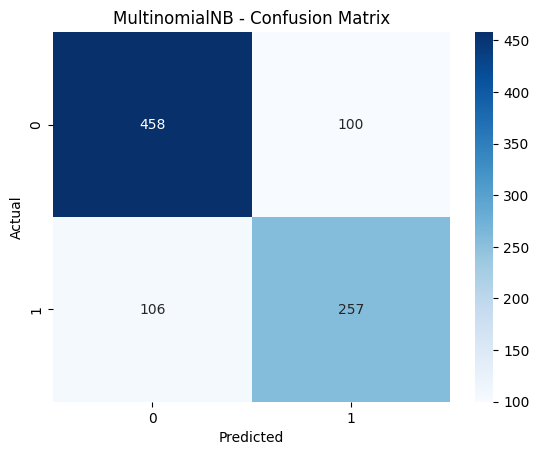

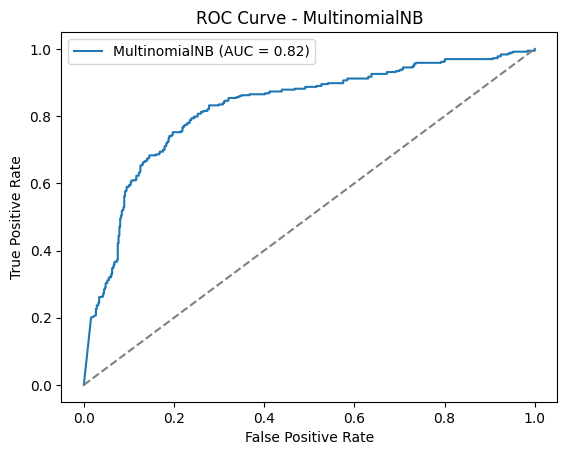

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       558
           1       0.87      0.80      0.84       363

    accuracy                           0.88       921
   macro avg       0.88      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921



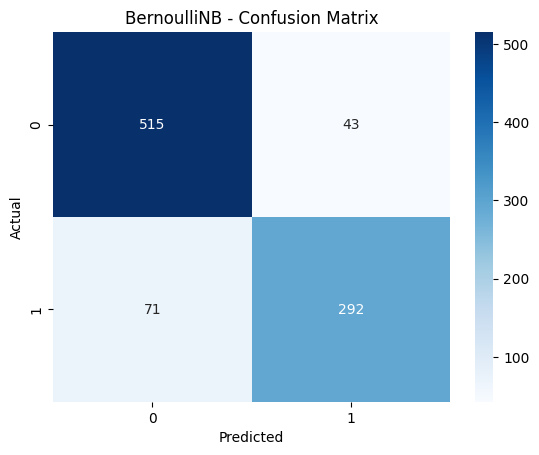

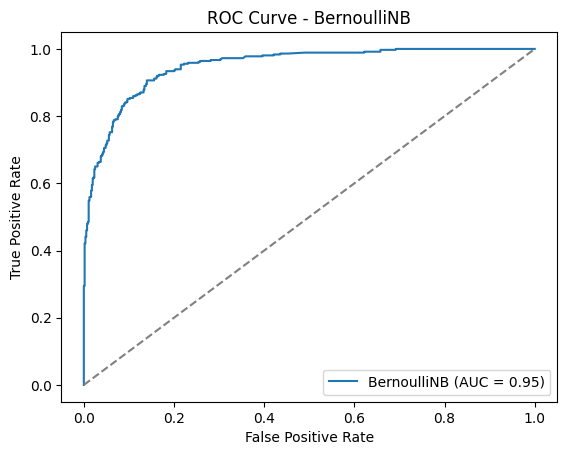

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       558
           1       0.88      0.87      0.87       363

    accuracy                           0.90       921
   macro avg       0.90      0.89      0.90       921
weighted avg       0.90      0.90      0.90       921



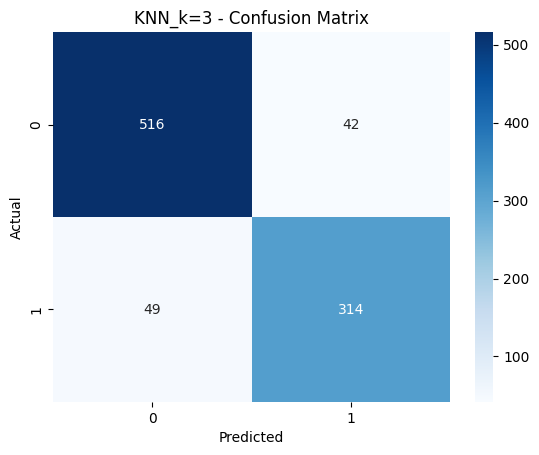

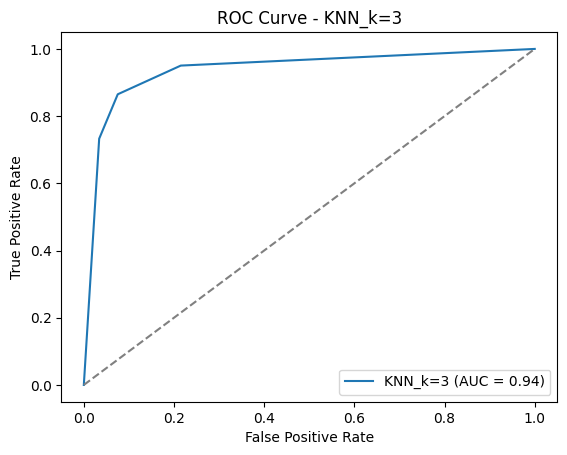

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       558
           1       0.89      0.87      0.88       363

    accuracy                           0.91       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921



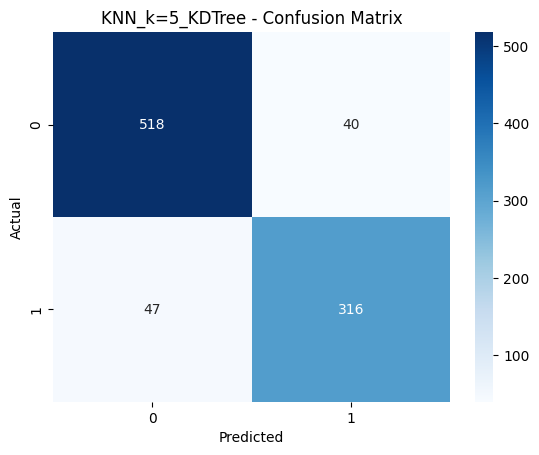

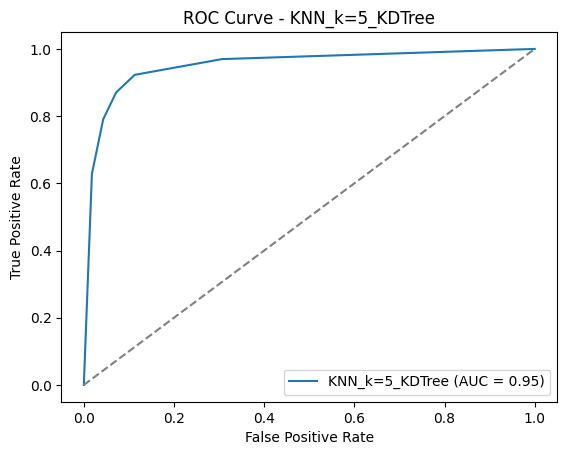

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       558
           1       0.89      0.87      0.88       363

    accuracy                           0.91       921
   macro avg       0.91      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921



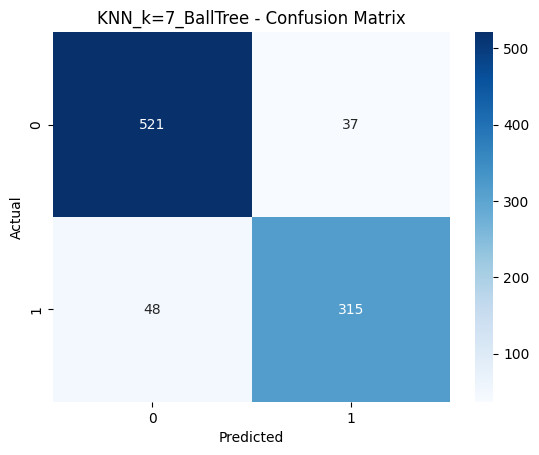

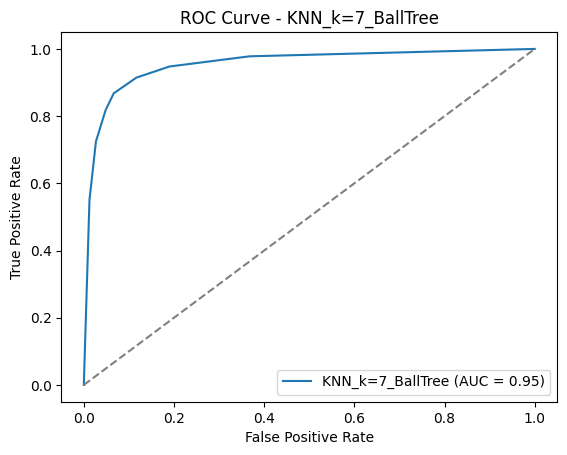

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       558
           1       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921



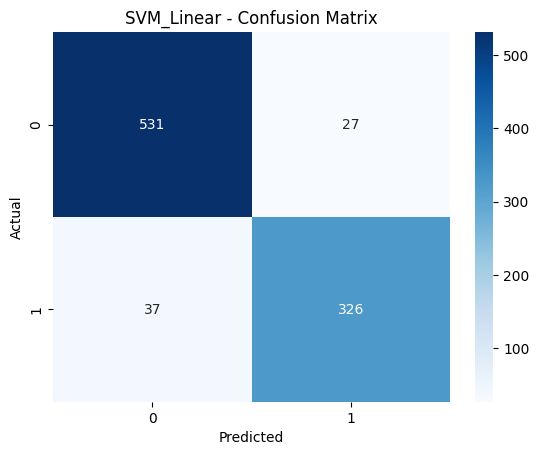

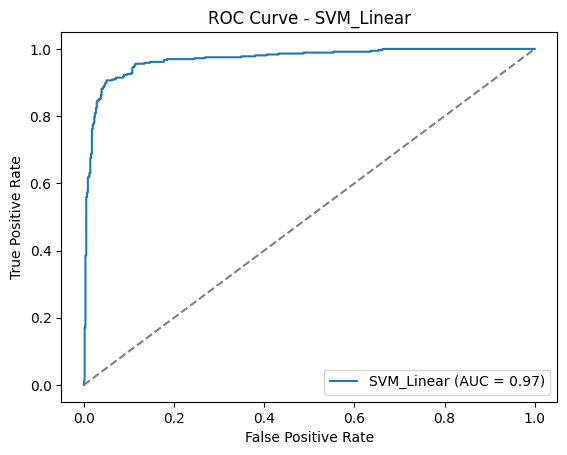

              precision    recall  f1-score   support

           0       0.74      0.99      0.84       558
           1       0.96      0.46      0.62       363

    accuracy                           0.78       921
   macro avg       0.85      0.72      0.73       921
weighted avg       0.83      0.78      0.76       921



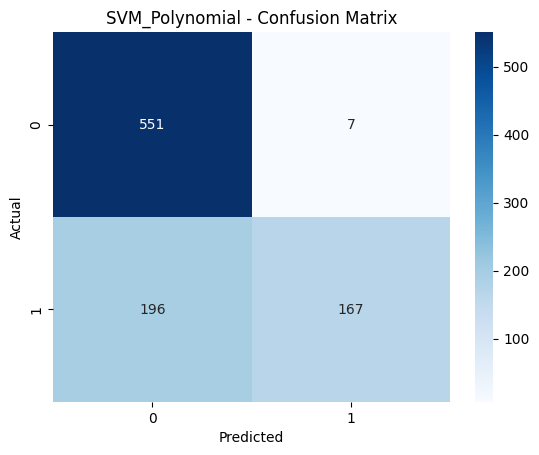

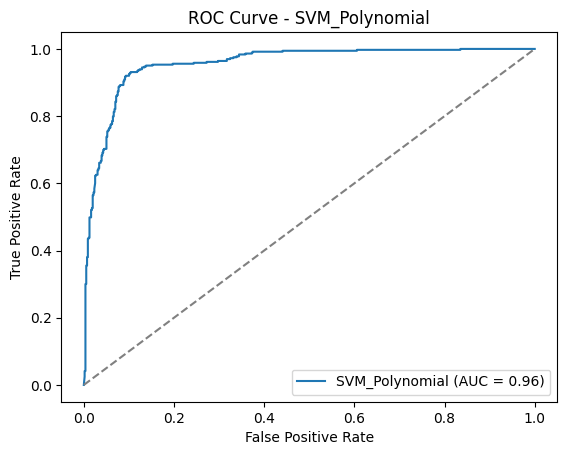

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       558
           1       0.93      0.88      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



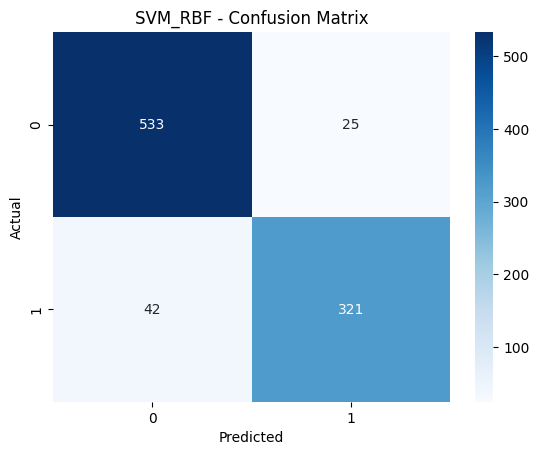

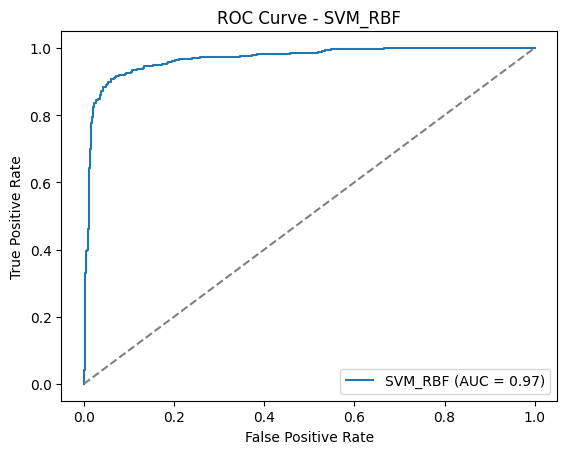

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       558
           1       0.85      0.85      0.85       363

    accuracy                           0.88       921
   macro avg       0.88      0.88      0.88       921
weighted avg       0.88      0.88      0.88       921



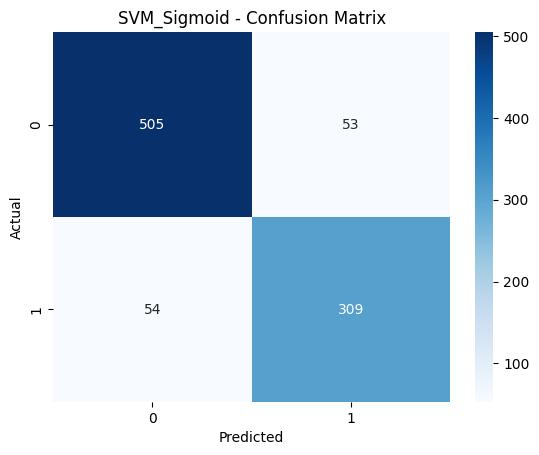

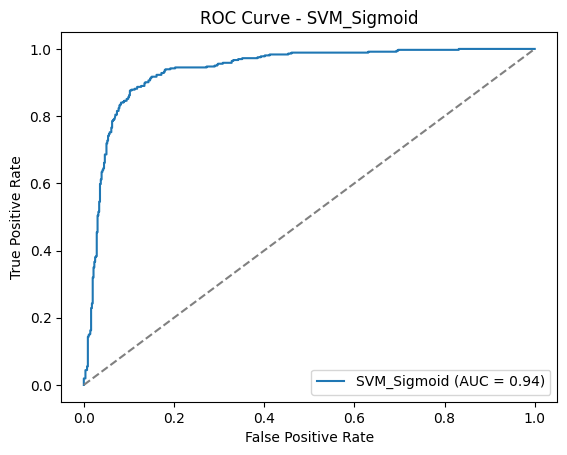

In [ ]:
# Naïve Bayes
nb_models = {k: v for k, v in models.items() if "NB" in k}
for name, model in nb_models.items():
    evaluate_and_store(name, model, X_raw_train, y_train, X_raw_test, y_test, "NB")

# KNN
knn_models = {k: v for k, v in models.items() if "KNN" in k}
knn_results = []  # Initialize knn_results list
def evaluate_and_store_knn(name, model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    knn_results.append([name, acc, prec, rec, f1, train_time]) # Store all KNN results here
    evaluate_model(name, model, X_test, y_test)

for name, model in knn_models.items():
    evaluate_and_store_knn(name, model, X_scaled_train, y_train, X_scaled_test, y_test)


# SVM
svm_models = {k: v for k, v in models.items() if "SVM" in k}
for name, model in svm_models.items():
    evaluate_and_store(name, model, X_scaled_train, y_train, X_scaled_test, y_test, "SVM")

6) K-Fold Cross Validation (K=5)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, model in models.items():
    if "MultinomialNB" in name:
        scores = cross_val_score(model, X_raw, y, cv=kfold, scoring='accuracy')
    else:
        scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='accuracy')
    for fold, score in enumerate(scores, start=1):
        cv_results.append([f"Fold {fold}", name, round(score, 4)])
    cv_results.append(["Average", name, round(scores.mean(), 4)])


7) Create Tables

In [ ]:
table1 = pd.DataFrame(nb_results, columns=["Naïve Bayes Variant", "Accuracy", "Precision", "Recall", "F1 Score", "Train Time(s)"])

# Filter KNN results into k-based and tree-based tables
table2 = pd.DataFrame([row for row in knn_results if "k=" in row[0]], columns=["k", "Accuracy", "Precision", "Recall", "F1 Score", "Train Time(s)"])
table3 = pd.DataFrame([row for row in knn_results if "Tree" in row[0]], columns=["Tree Type", "Accuracy", "Precision", "Recall", "F1 Score", "Train Time(s)"])

table4 = pd.DataFrame(svm_results, columns=["Kernel", "Accuracy", "F1 Score", "Train Time(s)"])
table5 = pd.DataFrame(cv_results, columns=["Fold", "Model", "Accuracy"])

# Function to print aligned tables for observation notebook
def print_observation_table(title, headers, data):
    print(title)
    print("-" * len(title))
    header_line = "  ".join(f"{h:<15}" for h in headers)
    print(header_line)
    for row in data:
        print("  ".join(f"{str(val):<15}" for val in row))
    print("\n")

# Print all tables
print_observation_table(
    "Table 1: Performance Comparison of Naïve Bayes Variants",
    ["Variant", "Accuracy", "Precision", "Recall", "F1 Score", "Train Time(s)"],
    table1.values
)
print_observation_table(
    "Table 2: KNN Performance for Different k Values",
    ["k", "Accuracy", "Precision", "Recall", "F1 Score"],
    table2[["k", "Accuracy", "Precision", "Recall", "F1 Score"]].values # Select columns for table 2
)
print_observation_table(
    "Table 3: KNN Comparison: KDTree vs BallTree",
    ["Tree Type", "Accuracy", "Precision", "Recall", "F1 Score", "Train Time(s)"],
    table3.values
)
print_observation_table(
    "Table 4: SVM Performance with Different Kernels and Parameters",
    ["Kernel", "Accuracy", "F1 Score", "Train Time(s)"],
    table4.values
)
print_observation_table(
    "Table 5: Cross-Validation Scores for Each Model",
    ["Fold", "Model", "Accuracy"],
    table5.values
)

Table 1: Performance Comparison of Naïve Bayes Variants
-------------------------------------------------------
Variant          Accuracy         Precision        Recall           F1 Score         Train Time(s)  
GaussianNB       0.8338762214983714  0.7178423236514523  0.953168044077135  0.8189349112426035  0.012166500091552734
MultinomialNB    0.7763300760043431  0.7198879551820728  0.7079889807162535  0.7138888888888889  0.009221076965332031
BernoulliNB      0.8762214983713354  0.8716417910447761  0.8044077134986226  0.836676217765043  0.01472926139831543


Table 2: KNN Performance for Different k Values
-----------------------------------------------
k                Accuracy         Precision        Recall           F1 Score       
KNN_k=3          0.9011943539630836  0.8820224719101124  0.8650137741046832  0.8734353268428373
KNN_k=5_KDTree   0.9055374592833876  0.8876404494382022  0.8705234159779615  0.8789986091794159
KNN_k=7_BallTree  0.9077090119435396  0.8948863636363636  0.86

8) Observation

In [ ]:
print("\n=== Observations ===")
print("Best overall accuracy model:", table4.loc[table4['Accuracy'].idxmax(), 'Kernel'])
print("Best Naïve Bayes variant:", table1.loc[table1['Accuracy'].idxmax(), 'Naïve Bayes Variant'])
print("Best KNN k-value:", table2.loc[table2['Accuracy'].idxmax(), 'k'])
print("Best KNN tree type:", table3.loc[table3['Accuracy'].idxmax(), 'Tree Type'])




=== Observations ===
Best overall accuracy model: SVM_Linear
Best Naïve Bayes variant: BernoulliNB
Best KNN k-value: KNN_k=7_BallTree
Best KNN tree type: KNN_k=7_BallTree


 EXTRA: Grid Search and Randomized Search for SVM

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

print("\n=== GRID SEARCH for SVM ===")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled_train, y_train)
print("Best Parameters (Grid Search):", grid_search.best_params_)
print("Best Accuracy (Grid Search):", round(grid_search.best_score_, 4))
y_pred_grid = grid_search.best_estimator_.predict(X_scaled_test)
print("Test Accuracy (Grid Search Best Model):", round(accuracy_score(y_test, y_pred_grid), 4))

print("\n=== RANDOMIZED SEARCH for SVM ===")
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}
random_search = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='accuracy', random_state=RANDOM_STATE)
random_search.fit(X_scaled_train, y_train)
print("Best Parameters (Randomized Search):", random_search.best_params_)
print("Best Accuracy (Randomized Search):", round(random_search.best_score_, 4))
y_pred_random = random_search.best_estimator_.predict(X_scaled_test)
print("Test Accuracy (Random Search Best Model):", round(accuracy_score(y_test, y_pred_random), 4))


=== GRID SEARCH for SVM ===
Best Parameters (Grid Search): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Grid Search): 0.934
Test Accuracy (Grid Search Best Model): 0.9273

=== RANDOMIZED SEARCH for SVM ===
Best Parameters (Randomized Search): {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best Accuracy (Randomized Search): 0.9332
Test Accuracy (Random Search Best Model): 0.9229
